
Linear Regression:
  Усредненный max_error (CV): 0.275455
  Max_error (test set): 0.180587

Ridge Regression:
  Усредненный max_error (CV): 0.275504
  Max_error (test set): 0.180593

Оптимизация параметров для SVR...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Лучшие параметры: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}

SVR:
  Усредненный max_error (CV): 0.208501
  Max_error (test set): 0.211118


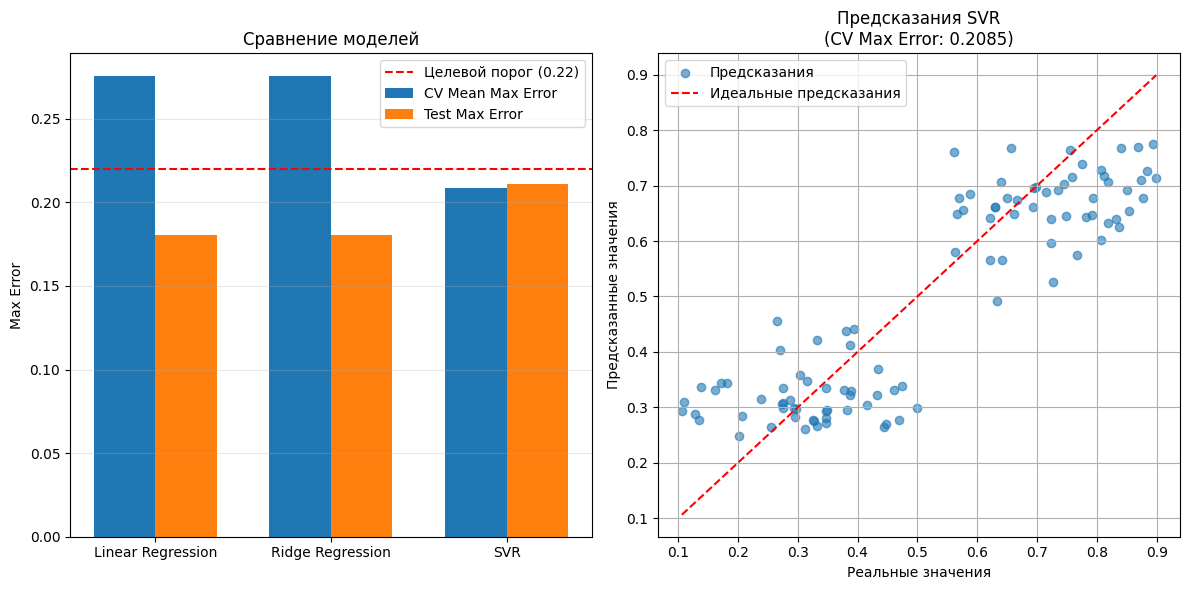


Лучшая модель: SVR
Усредненная максимальная ошибка: 0.208501

Анализ коэффициентов линейных моделей:

Linear Regression коэффициенты:
  x1: 0.0151
  x2: 0.1726
  x3: -0.0357


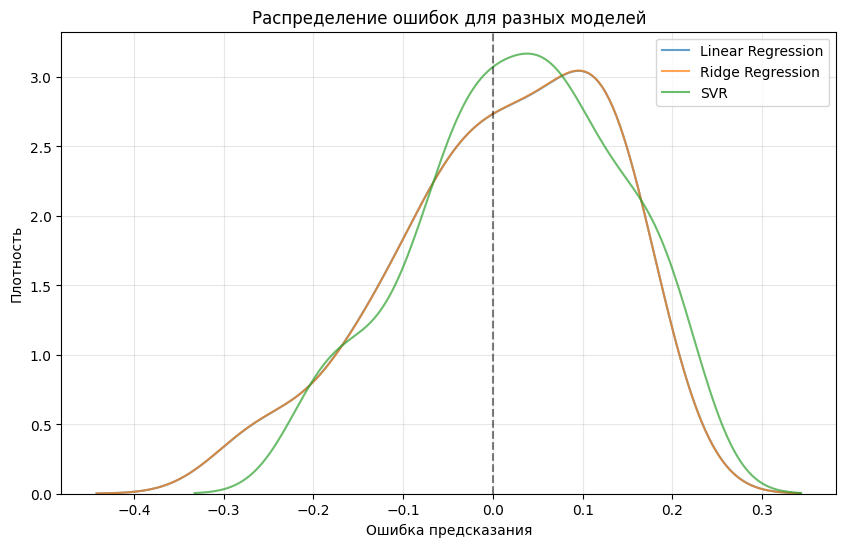

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error

# Загрузка данных
data = pd.read_csv('dataset_01.csv', sep=';')
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Список моделей для сравнения
models = {
    "Linear Regression": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge Regression": make_pipeline(StandardScaler(), Ridge(alpha=0.1)),
    "SVR": make_pipeline(StandardScaler(), SVR(kernel='rbf'))
}

# Параметры для GridSearch (только для SVR)
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': [0.01, 0.1, 1, 10],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.2]
}

# Результаты сравнения
results = []

# Обучение и оценка моделей
for name, model in models.items():
    if name == "SVR":
        # Для SVR используем поиск по сетке
        print(f"\nОптимизация параметров для {name}...")
        grid = GridSearchCV(model, param_grid, cv=5, 
                           scoring='neg_max_error', n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Лучшие параметры: {grid.best_params_}")
    else:
        # Для линейных моделей просто обучаем
        best_model = model
        best_model.fit(X_train, y_train)
    
    # Кросс-валидация на полных данных
    scores = cross_val_score(
        best_model, X, y, cv=5, scoring='neg_max_error'
    )
    mean_max_error = np.mean(np.abs(scores))
    
    # Тестовая оценка
    y_pred = best_model.predict(X_test)
    test_max_error = max_error(y_test, y_pred)
    
    results.append({
        "model": name,
        "mean_max_error": mean_max_error,
        "test_max_error": test_max_error,
        "model_obj": best_model
    })
    
    print(f"\n{name}:")
    print(f"  Усредненный max_error (CV): {mean_max_error:.6f}")
    print(f"  Max_error (test set): {test_max_error:.6f}")

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

# График 1: Сравнение ошибок
plt.subplot(1, 2, 1)
cv_errors = [res["mean_max_error"] for res in results]
test_errors = [res["test_max_error"] for res in results]
model_names = [res["model"] for res in results]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, cv_errors, width, label='CV Mean Max Error')
plt.bar(x + width/2, test_errors, width, label='Test Max Error')
plt.axhline(y=0.22, color='r', linestyle='--', label='Целевой порог (0.22)')
plt.xticks(x, model_names)
plt.ylabel('Max Error')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# График 2: Предсказания лучшей модели
best_result = min(results, key=lambda x: x["mean_max_error"])
best_model = best_result["model_obj"]
y_pred_all = best_model.predict(X)

plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_all, alpha=0.6, label='Предсказания')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальные предсказания')
plt.title(f'Предсказания {best_result["model"]}\n(CV Max Error: {best_result["mean_max_error"]:.4f})')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Вывод лучшей модели
print("\n" + "="*50)
print(f"Лучшая модель: {best_result['model']}")
print(f"Усредненная максимальная ошибка: {best_result['mean_max_error']:.6f}")
print("="*50)

# Дополнительный анализ: Коэффициенты линейных моделей
print("\nАнализ коэффициентов линейных моделей:")
for res in results:
    if "Linear" in res["model"]:
        try:
            # Для Ridge и LinearRegression
            model = res["model_obj"]
            coefs = model.named_steps['ridge'].coef_ if "Ridge" in res["model"] else \
                    model.named_steps['linearregression'].coef_
            
            print(f"\n{res['model']} коэффициенты:")
            for i, col in enumerate(X.columns):
                print(f"  {col}: {coefs[i]:.4f}")
        except:
            pass

# Сравнение распределения ошибок
plt.figure(figsize=(10, 6))
for res in results:
    model = res["model_obj"]
    y_pred = model.predict(X)
    errors = y - y_pred
    sns.kdeplot(errors, label=res["model"], alpha=0.7)

plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('Распределение ошибок для разных моделей')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()